In [1]:
# Reading all of the csv files
import pandas as pd
stations = pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/stations_latlong.csv')
trips = pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/trips.csv')
weather = pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/weather.csv')
count_traffic= pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/count_metadata.csv')
locations=pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/locations.csv')
raw_traffic_2010s= pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/raw-data-2010-2019.csv')
raw_traffic_2020s= pd.read_csv('/Users/fabjoseph/Desktop/CSE_Project/data/raw/raw-data-2020-2029.csv')

#Merging traffic data so its all in one
raw_traffic = pd.concat([raw_traffic_2010s, raw_traffic_2020s], ignore_index=True)

In [2]:
#Filtering all of the datasets to  februaury 2019 because finding the closest street in the traffic dataset to all the bike stations takes a long time.
trips['start_date'] = pd.to_datetime(trips['start_date']) # Convert column to datetime so I can filter
weather['date'] = pd.to_datetime(weather['date'])# Convert column to datetime so I can filter
raw_traffic['count_date'] = pd.to_datetime(raw_traffic['count_date']) # Convert column to datetime so I can filter


# Now filter the datasets for February 2019
stations = stations[stations['yearid'] == 2019]
trips = trips[(trips['yearid'] == 2019) & (trips['start_date'].dt.month == 2)]
weather = weather[(weather['date'].dt.year == 2019) & (weather['date'].dt.month == 2)]
raw_traffic = raw_traffic[(raw_traffic['count_date'].dt.year == 2019) & (raw_traffic['count_date'].dt.month == 2)]

In [3]:
#Creating function to find closest street in traffic data to bike stations

from geopy.distance import geodesic #distance package
from tqdm import tqdm #progress bar
tqdm.pandas() # Show progress bar
# Function to find the nearest traffic location for each bike station
def find_nearest_traffic_station(station_lat, station_lng, traffic_df):
    traffic_locations = traffic_df[['lat', 'lng']].values
    station_location = (station_lat, station_lng)
    distances = [geodesic(station_location, (lat, lng)).meters for lat, lng in traffic_locations]
    nearest_idx = distances.index(min(distances))
    return traffic_df.iloc[nearest_idx]  # Return the nearest traffic location's row
# Create empty lists to store the results
nearest_traffic_location = []
nearest_traffic_id = []
# Loop through each station and apply the function
for index, row in tqdm(stations.iterrows(), total=stations.shape[0]):
    nearest_traffic = find_nearest_traffic_station(row['latitude'], row['longitude'], raw_traffic)
    nearest_traffic_location.append(nearest_traffic['location'])
    nearest_traffic_id.append(nearest_traffic['location_id'])
# Assign the nearest location and ID to new columns in stations dataset
stations['nearest_traffic_location'] = nearest_traffic_location
stations['nearest_traffic_id'] = nearest_traffic_id
# Merge!
merged_data = stations.merge(raw_traffic, left_on='nearest_traffic_id', right_on='location_id', suffixes=('_station', '_traffic'))

100%|█████████████████████████████████████████| 469/469 [01:19<00:00,  5.91it/s]


In [4]:
merged_data.head() #what it looks like

,code,name,latitude,longitude,yearid,nearest_traffic_location,nearest_traffic_id,_id,count_id,count_date,...,ex_peds,wx_peds,nx_bike,sx_bike,ex_bike,wx_bike,nx_other,sx_other,ex_other,wx_other
0,0,Bay St / Albert St,43.652962,-79.382633,2019,ALBERT ST AT BAY ST (PX 65),5421,203999,38339,2019-02-02,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Bay St / Albert St,43.652962,-79.382633,2019,ALBERT ST AT BAY ST (PX 65),5421,204000,38339,2019-02-02,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Bay St / Albert St,43.652962,-79.382633,2019,ALBERT ST AT BAY ST (PX 65),5421,204001,38339,2019-02-02,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Bay St / Albert St,43.652962,-79.382633,2019,ALBERT ST AT BAY ST (PX 65),5421,204002,38339,2019-02-02,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Bay St / Albert St,43.652962,-79.382633,2019,ALBERT ST AT BAY ST (PX 65),5421,204003,38339,2019-02-02,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Aggregate traffic data because we need each row to be a different station with its agrgegated traffic metrics

#List of traffic columns to sum (only the numeric traffic columns make sense to me to sum)
columns_to_sum = [
    'sb_cars_r', 'sb_cars_t', 'sb_cars_l', 'nb_cars_r', 'nb_cars_t', 'nb_cars_l', 'wb_cars_r', 'wb_cars_t', 'wb_cars_l',
    'eb_cars_r', 'eb_cars_t', 'eb_cars_l', 'sb_truck_r', 'sb_truck_t', 'sb_truck_l', 'nb_truck_r', 'nb_truck_t', 'nb_truck_l',
    'wb_truck_r', 'wb_truck_t', 'wb_truck_l', 'eb_truck_r', 'eb_truck_t', 'eb_truck_l', 'sb_bus_r', 'sb_bus_t', 'sb_bus_l',
    'nb_bus_r', 'nb_bus_t', 'nb_bus_l', 'wb_bus_r', 'wb_bus_t', 'wb_bus_l', 'eb_bus_r', 'eb_bus_t', 'eb_bus_l',
    'nx_peds', 'sx_peds', 'ex_peds', 'wx_peds', 'nx_bike', 'sx_bike', 'ex_bike', 'wx_bike', 'nx_other', 'sx_other',
    'ex_other', 'wx_other'
]
# Group by street name and sum the other numeric columns
aggregated_data = merged_data.groupby(['code', 'name']).agg({
    **{col: 'sum' for col in columns_to_sum},  # Sum traffic counts and relevant columns
    '_id': 'first',  # Keep the first value of _id 
    'count_id': 'first',  # Keep the first value of count_id
    'nearest_traffic_location': 'first',  # Keep the nearest traffic location (non-numeric field)
    'nearest_traffic_id': 'first',  # Keep the nearest traffic ID
}).reset_index()

# Reorder columns so its clear
columns = ['name', 'nearest_traffic_location'] + [col for col in aggregated_data.columns if col not in ['name', 'latitude', 'longitude', 'nearest_traffic_location']]

# Save to new dataframe
aggregated_data = aggregated_data[columns]

# Show preview of data
aggregated_data.head()

,name,nearest_traffic_location,code,sb_cars_r,sb_cars_t,sb_cars_l,nb_cars_r,nb_cars_t,nb_cars_l,wb_cars_r,...,sx_bike,ex_bike,wx_bike,nx_other,sx_other,ex_other,wx_other,_id,count_id,nearest_traffic_id
0,Bay St / Albert St,ALBERT ST AT BAY ST (PX 65),0,0.0,3335.0,0.0,2.0,3579.0,0.0,512.0,...,40.0,0.0,3.0,0.0,0.0,0.0,0.0,203999,38339,5421
1,King St W / Tecumseth St,KING ST W AT SPADINA AVE,1,346.0,4460.0,3.0,298.0,5305.0,585.0,263.0,...,4.0,5.0,31.0,0.0,0.0,0.0,0.0,205242,38415,4177
2,Jarvis St / Carlton St,BAY ST AT COLLEGE ST (PX 68),2,668.0,4456.0,2.0,781.0,4551.0,3.0,640.0,...,139.0,158.0,134.0,0.0,0.0,0.0,0.0,205693,38439,4611
3,Elizabeth St / Edward St (Bus Terminal),BAY ST AT DUNDAS ST W (PX 66),3,570.0,3785.0,7.0,613.0,3582.0,721.0,840.0,...,106.0,119.0,100.0,0.0,0.0,0.0,0.0,205848,38447,5292
4,Edward St / Yonge St,BAY ST AT DUNDAS ST W (PX 66),4,570.0,3785.0,7.0,613.0,3582.0,721.0,840.0,...,106.0,119.0,100.0,0.0,0.0,0.0,0.0,205848,38447,5292


In [6]:
#Now merge bike trip counts with aggregated station-traffic data

import warnings # Suppress all warnings
warnings.filterwarnings('ignore') # Suppress all warnings


trip_counts = trips.groupby('start_station_code').size().reset_index(name='trip_count')  # Get trip count for each station code

station_trip_traffic = aggregated_data.merge(trip_counts, left_on='code', right_on='start_station_code', how='left') # Merge trip with bike info

station_trip_traffic['trip_count'].fillna(0, inplace=True) # Fill NA values (stations with no trips) with 0

# Filter out rows where trip_count is 0 because something weird is probably happening here
station_trip_traffic_filtered = station_trip_traffic[station_trip_traffic['trip_count'] > 0]




# Summing up bike and traffic metrics so we can do a quick correlation matrix
station_trip_traffic_filtered['total_bike_traffic'] = station_trip_traffic_filtered[['nx_bike', 'sx_bike', 'ex_bike', 'wx_bike']].sum(axis=1)
station_trip_traffic_filtered['total_peds'] = station_trip_traffic_filtered[['nx_peds', 'sx_peds', 'ex_peds', 'wx_peds']].sum(axis=1)
station_trip_traffic_filtered['total_cars'] = station_trip_traffic_filtered[['sb_cars_r', 'nb_cars_r', 'wb_cars_r', 'eb_cars_r']].sum(axis=1)

# Create Correlation matrix
correlation_matrix = station_trip_traffic_filtered[['trip_count', 'total_bike_traffic', 'total_peds', 'total_cars']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                    trip_count  total_bike_traffic  total_peds  total_cars
trip_count            1.000000            0.365140    0.447501   -0.019120
total_bike_traffic    0.365140            1.000000    0.380474    0.510965
total_peds            0.447501            0.380474    1.000000    0.190311
total_cars           -0.019120            0.510965    0.190311    1.000000


Ineffective Stations:
                                          name  trip_count
173              Wellington St W / Stafford St        24.0
303  Sorauren/Geoffrey (Sorauren Park) - SMART        11.0


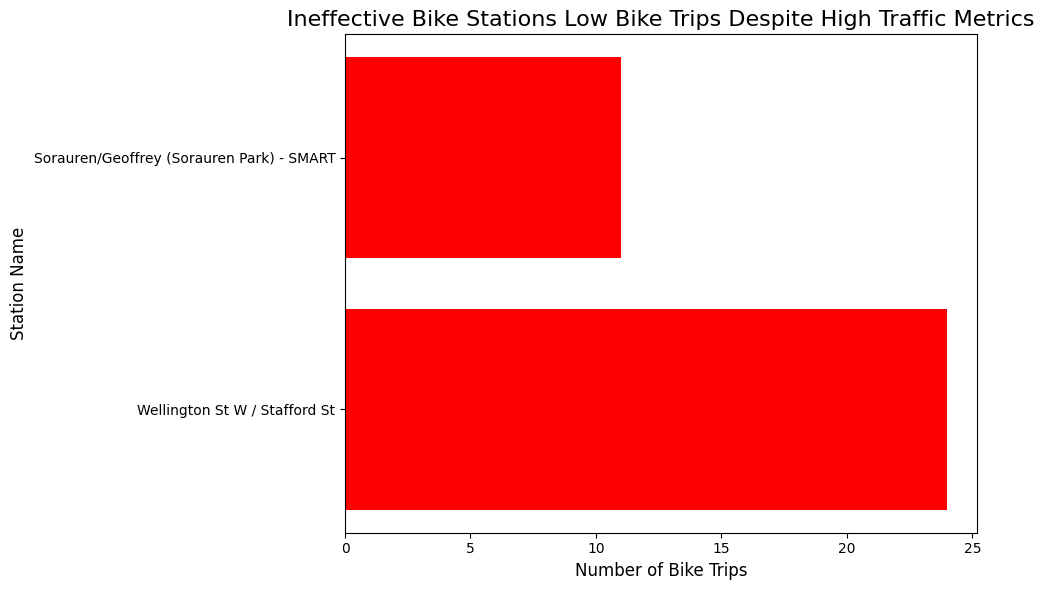

In [8]:

# Identifying ineffective bike stations. Which are stations where there is high traffic but low trip bike usage. 

traffic_threshold = station_trip_traffic_filtered['total_bike_traffic'].quantile(0.75) #the top 25% of stations with the highest traffic counts are considered "high traffic."
usage_threshold = station_trip_traffic_filtered['trip_count'].quantile(0.25) #the bottom 25% of stations with the fewest bike trips are considered "low usage."

ineffective_stations = station_trip_traffic_filtered[(station_trip_traffic_filtered['total_bike_traffic'] > traffic_threshold) & 
                                                     (station_trip_traffic_filtered['trip_count'] < usage_threshold)] #filtering for ineffective

print("Ineffective Stations:") #show ineffective stations and their trip count
print(ineffective_stations[['name', 'trip_count']]) #show ineffective stations and their trip count

# Visualizing ineffective stations
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(ineffective_stations['name'], ineffective_stations['trip_count'], color='red')
plt.title('Ineffective Bike Stations Low Bike Trips Despite High Traffic Metrics', fontsize=16)
plt.xlabel('Number of Bike Trips', fontsize=12)
plt.ylabel('Station Name', fontsize=12)
plt.tight_layout()
plt.show()